<a href="https://colab.research.google.com/github/carversh/DL_sc/blob/main/compute_rsq_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import pandas as pd
!pip install spams
import spams
!pip install mpu
import mpu
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the current working directory
os.chdir('/content/drive/MyDrive/AM231_project')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp310-cp310-linux_x86_64.whl size=4490007 sha256=ad120de8239d47b5e5141f8c2e35b5f8c552c89080ec92e925c7f045a95b9028
  Stored in directory: /root/.cache/pip/wheels/67/9d/1f/60a6c60785b07ad4f087297f04b723e665a97afcd5112ffb06
Successfully built spams
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 1.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import time, sys, traceback, argparse
import tqdm
import statsmodels.api as sma
import statsmodels.stats as sms
import functools
from tqdm.contrib.concurrent import thread_map
import argparse
import torch
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd

In [ ]:
def scale_effs(B, logmeanexp, downsample_num = 25000, log_exp_baseline = 2):
    '''
    Scale effect sizes to mean expression using LOWESS.

    Parameters
    ----------
    B: Perturbation x gene unscaled effect size matrix
    logmeanexp: Vector of log mean expression values to scale to
    downsample_num: Number of effects used to fit curve
    log_exp_baseline: Mean effect magnitude from this log expression is taken as the value to scale to

    Returns
    ---------
    B: Perturbation x gene scaled effect size matrix
    scale_factors: Per-gene scale factors
    '''

    data_frac = min(1, downsample_num / np.prod(B.shape))

    if B.shape[1] != len(logmeanexp):
        raise ValueError('Number of genes differs')
    rand_idx = np.c_[np.random.randint(0, B.shape[0], downsample_num),
                     np.random.randint(0, B.shape[1], downsample_num)]
    to_plot = np.c_[logmeanexp[rand_idx[:,1]], np.log(np.abs(B[rand_idx[:,0],rand_idx[:,1]]))]
    to_plot = to_plot[~np.isinf(to_plot[:,1]),:]
    fit = sma.nonparametric.lowess(to_plot[:,1], to_plot[:,0], return_sorted=False, xvals = logmeanexp)
    baseline = fit[min(i for i,x in enumerate(logmeanexp) if x > log_exp_baseline)]
    scale_factors = np.exp(fit - baseline)
    B = B / scale_factors
    return B, scale_factors

def signif(X, n):
    '''Round elements of a pandas DF X to n significant figures'''
    def func(x):
        if x == 0:
            return 0
        else:
            return round(x, n - 1 - int(np.floor(np.log10(abs(x)))))
    return X.applymap(func)

In [ ]:
# read in necessary dataframes
logmeanexp_guide_pool = np.load('./data/guide_pooled_processed_logmeanexp.npy')
logmeanexp_conven = np.load('./data/conventional_processed_logmeanexp.npy')

conventional_indicator = pd.read_csv('./data/GSM6858447_KO_conventional_perturbations.txt', index_col = 0, delim_whitespace=True)
indic_conven = conventional_indicator.index
keep_cells_conven = conventional_indicator.sum(axis = 0) > 0
conventional_indicator = np.asfortranarray(conventional_indicator.loc[:, keep_cells_conven].T).astype(float)
genes_guide_conven = pd.read_csv('./data/conventional_processed_gene_names.txt', sep = '\t')
genes_guide_conven = genes_guide_conven[['features']]


guide_pool_indicator =  pd.read_csv('./data/GSM6858450_KD_guide_pooled_perturbations.txt', index_col = 0, delim_whitespace=True)
indic_guide = guide_pool_indicator.index
keep_cells_guide_pool = guide_pool_indicator.sum(axis = 0) > 0
guide_pool_indicator = np.asfortranarray(guide_pool_indicator.loc[:, keep_cells_guide_pool].T).astype(float)
genes_guide_pooled = pd.read_csv('./data/guide_pooled_processed_gene_names.txt', sep = '\t')
genes_guide_pooled = genes_guide_pooled[['features']]

In [ ]:
guide_folder = "guide_pooled_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_00_12"
torch_code_guide = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{guide_folder}/code_guide_pooled_final_unrolled.npy").astype(float)
torch_dict_guide = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{guide_folder}/dictionary_guide_pooled_final_unrolled.npy").astype(float)

conven_folder = "conventional_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_25_03"
torch_code_conven = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{conven_folder}/code_conventional_final_unrolled.npy").astype(float)
torch_dict_conven = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{conven_folder}/dictionary_conventional_final_unrolled.npy").astype(float)

U = spams.lasso(np.asfortranarray(torch_code_guide), D=np.asfortranarray(guide_pool_indicator), lambda1=10, verbose=False)
B = U.dot(torch_dict_guide.T)
B,_ = scale_effs(B, logmeanexp_guide_pool)

B = pd.DataFrame(data = np.transpose(B), index = genes_guide_pooled, columns = indic_guide)
B_guide_pooled = signif(B, 3)

###

U = spams.lasso(np.asfortranarray(torch_code_conven), D=conventional_indicator, lambda1=10, verbose=False)
B = U.dot(torch_dict_conven.T)
B,_ = scale_effs(B, logmeanexp_conven)

B = pd.DataFrame(data = np.transpose(B), index = genes_guide_conven, columns = indic_conven)
B_conven = signif(B, 3)

In [ ]:
outputs = {}
df1 = B_guide_pooled
df2 = B_conven
number_top_effect_sizes = 1000

# find intersecting genes
inter_genes = list(set(df1.index) & set(df2.index) )

# find intersecting perturbations
inter_perturb = list(set(df1.columns) & set(df2.columns) )

# subset dataframes by intersections
df1 = df1.loc[inter_genes, inter_perturb]
df2 = df2.loc[inter_genes, inter_perturb]

vars=list(df1.columns)
df1_flatten = pd.melt(df1, value_vars=vars,value_name='Effect_Size', ignore_index=False)
df1_flatten['gene'] = df1_flatten.index

vars=list(df2.columns)
df2_flatten = pd.melt(df2, value_vars=vars,value_name='Effect_Size', ignore_index=False)
df2_flatten['gene'] = df2_flatten.index


df1_flatten['abs_Effect_Size'] = df1_flatten['Effect_Size'].abs()

sub_df1_flatten = df1_flatten.nlargest(number_top_effect_sizes, 'abs_Effect_Size', keep='all')
sub_df1_flatten['gene'] = sub_df1_flatten.index

merged = sub_df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
merged = merged[['variable','gene','Effect_Size_x','Effect_Size_y']]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged[['Effect_Size_x', 'Effect_Size_y' ]]))
outputs[f"r_sq_{number_top_effect_sizes}_top_effects"] = np.round(r_value**2,5)
outputs[f"sq_dist_{number_top_effect_sizes}_top_effects"] = np.sum((merged['Effect_Size_x'] - merged['Effect_Size_y']) **2)

merged = df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged[['Effect_Size_x','Effect_Size_y']]))
outputs["r_sq_all_effects"] = np.round(r_value**2,5)
outputs[f"sq_dist_all_effects"] = np.sum((merged['Effect_Size_x'] - merged['Effect_Size_y']) **2)

In [ ]:
outputs

{'r_sq_1000_top_effects': 0.65357,
 'sq_dist_1000_top_effects': 116.82958644221799,
 'r_sq_all_effects': 0.04687,
 'sq_dist_all_effects': 35227.95370406443}

In [ ]:
def analyze(guide_folder, conven_folder):
  torch_code_guide = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{guide_folder}/code_guide_pooled_final_unrolled.npy").astype(float)
  torch_dict_guide = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{guide_folder}/dictionary_guide_pooled_final_unrolled.npy").astype(float)
  torch_code_conven = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{conven_folder}/code_conventional_final_unrolled.npy").astype(float)
  torch_dict_conven = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{conven_folder}/dictionary_conventional_final_unrolled.npy").astype(float)

  U = spams.lasso(np.asfortranarray(torch_code_guide), D=np.asfortranarray(guide_pool_indicator), lambda1=10, verbose=False)
  B = U.dot(torch_dict_guide.T)
  B,_ = scale_effs(B, logmeanexp_guide_pool)

  B = pd.DataFrame(data = np.transpose(B), index = genes_guide_pooled, columns = indic_guide)
  B_guide_pooled = signif(B, 3)

  ###

  U = spams.lasso(np.asfortranarray(torch_code_conven), D=conventional_indicator, lambda1=10, verbose=False)
  B = U.dot(torch_dict_conven.T)
  B,_ = scale_effs(B, logmeanexp_conven)

  B = pd.DataFrame(data = np.transpose(B), index = genes_guide_conven, columns = indic_conven)
  B_conven = signif(B, 3)

  outputs = {}
  df1 = B_guide_pooled
  df2 = B_conven
  number_top_effect_sizes = 1000

  # find intersecting genes
  inter_genes = list(set(df1.index) & set(df2.index) )

  # find intersecting perturbations
  inter_perturb = list(set(df1.columns) & set(df2.columns) )

  # subset dataframes by intersections
  df1 = df1.loc[inter_genes, inter_perturb]
  df2 = df2.loc[inter_genes, inter_perturb]

  vars=list(df1.columns)
  df1_flatten = pd.melt(df1, value_vars=vars,value_name='Effect_Size', ignore_index=False)
  df1_flatten['gene'] = df1_flatten.index

  vars=list(df2.columns)
  df2_flatten = pd.melt(df2, value_vars=vars,value_name='Effect_Size', ignore_index=False)
  df2_flatten['gene'] = df2_flatten.index


  df1_flatten['abs_Effect_Size'] = df1_flatten['Effect_Size'].abs()

  sub_df1_flatten = df1_flatten.nlargest(number_top_effect_sizes, 'abs_Effect_Size', keep='all')
  sub_df1_flatten['gene'] = sub_df1_flatten.index

  merged = sub_df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
  merged = merged[['variable','gene','Effect_Size_x','Effect_Size_y']]
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged[['Effect_Size_x', 'Effect_Size_y' ]]))
  outputs[f"r_sq_{number_top_effect_sizes}_top_effects"] = np.round(r_value**2,5)
  outputs[f"sq_dist_{number_top_effect_sizes}_top_effects"] = np.sum((merged['Effect_Size_x'] - merged['Effect_Size_y']) **2)

  merged = df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged[['Effect_Size_x','Effect_Size_y']]))
  outputs["r_sq_all_effects"] = np.round(r_value**2,5)
  outputs[f"sq_dist_all_effects"] = np.sum((merged['Effect_Size_x'] - merged['Effect_Size_y']) **2)
  return outputs

In [ ]:
def add_to_df(guide_folder, conven_folder, name, df=None):
  lapl = analyze(guide_folder=guide_folder, conven_folder=conven_folder)
  lapl["name"] = name
  if df is None:
    df = pd.DataFrame(lapl, index=[0])
  else:
    df = pd.concat([df, pd.DataFrame(lapl, index=[0])])
  return df


In [ ]:
df = add_to_df(guide_folder="guide_pooled_lapl_genes_1500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_05_04_53", conven_folder="conventional_lapl_genes_1500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_05_40_40", name=1500)




In [ ]:
df = add_to_df(guide_folder="guide_pooled_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_07_58_18", conven_folder="conventional_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_08_34_46" , name=500 , df=df)
df

,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,name
0,0.59318,255.487399,0.04396,53533.072430,1500
0,0.57482,272.726159,0.04395,54521.549458,500


In [ ]:
df = add_to_df(guide_folder="guide_pooled_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_07_58_18", conven_folder="conventional_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_08_34_46" , name=500 , df=df)

df = add_to_df(guide_folder="guide_pooled_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_10_55_54", conven_folder="conventional_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_04_03_17_03" , name= 100, df=df)

df = add_to_df(guide_folder="guide_pooled_lapl_genes_1_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_05_21_48_34", conven_folder="conventional_lapl_genes_1_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_05_22_24_54" , name= 1 , df=df)

df = add_to_df(guide_folder="guide_pooled_lapl_genes_10_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_06_00_43_17", conven_folder="conventional_lapl_genes_10_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_06_01_19_20" , name= 10, df=df)


In [ ]:
df = add_to_df(guide_folder="guide_pooled_lapl_genes_0_250_epochs_update_lasso_per_it_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_16_23_57", conven_folder="conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19" , name=0 , df=df)

#df = add_to_df(guide_folder="", conven_folder="" , name= , df=df)

In [ ]:
df = df.sort_values(by=['name'])

In [ ]:
df.to_csv('laplacians_init_with_pytorch_dict_plus_vanilla.csv')


In [ ]:
df = pd.read_csv('laplacians_init_with_pytorch_dict_plus_vanilla.csv',header=0)
df

,Unnamed: 0,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,name
0,0,0.59318,255.487399,0.04396,53533.072430,1500
1,0,0.57482,272.726159,0.04395,54521.549458,500
2,0,0.58000,276.179991,0.04407,56264.983967,500
3,0,0.57845,323.778647,0.04374,62508.810826,100
4,0,0.59364,255.018968,0.04415,53646.555704,1
5,0,0.56370,268.728299,0.04411,54374.854345,10
6,0,0.75198,96.133416,0.05374,33298.662587,0


In [ ]:
df = add_to_df(guide_folder="guide_pooled_lapl_genes_0point01_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_07_05_41_55", conven_folder="conventional_lapl_genes_0point01_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_07_06_19_43" , name=0.01 , df=df)

df = add_to_df(guide_folder="guide_pooled_lapl_genes_1_update_lasso_0point1_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_07_02_40_55", conven_folder="conventional_lapl_genes_1_update_lasso_0point1_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_07_03_18_27" , name= 0.1, df=df)

df = add_to_df(guide_folder="guide_pooled_lapl_genes_0_batch_512_initial_dict_data_correct_lr_lambda_0.1_laplacian_True_epochs_250_2023_06_07_01_11_30", conven_folder="conventional_lapl_genes_0_batch_512_initial_dict_data_correct_lr_lambda_0.1_laplacian_True_epochs_250_2023_06_06_22_44_20" , name= 0, df=df)

In [ ]:
df

,Unnamed: 0,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,name
0,0.0,0.59318,255.487399,0.04396,53533.072430,1500.00
1,0.0,0.57482,272.726159,0.04395,54521.549458,500.00
2,0.0,0.58000,276.179991,0.04407,56264.983967,500.00
3,0.0,0.57845,323.778647,0.04374,62508.810826,100.00
4,0.0,0.59364,255.018968,0.04415,53646.555704,1.00
5,0.0,0.56370,268.728299,0.04411,54374.854345,10.00
6,0.0,0.75198,96.133416,0.05374,33298.662587,0.00
0,NaN,0.62847,202.786596,0.04588,50762.223868,0.01
0,NaN,0.59350,249.316827,0.04479,54966.232747,0.10
0,NaN,0.68404,124.592984,0.05092,36563.528691,0.00


In [ ]:
df.rename(columns={'name':'lambda_laplacian'}, inplace=True)
df = df.sort_values(by=['lambda_laplacian'])
df = df.drop(['Unnamed: 0'], axis=1)
df

,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,lambda_laplacian
6,0.75198,96.133416,0.05374,33298.662587,0.00
0,0.68404,124.592984,0.05092,36563.528691,0.00
0,0.62847,202.786596,0.04588,50762.223868,0.01
0,0.59350,249.316827,0.04479,54966.232747,0.10
4,0.59364,255.018968,0.04415,53646.555704,1.00
5,0.56370,268.728299,0.04411,54374.854345,10.00
3,0.57845,323.778647,0.04374,62508.810826,100.00
1,0.57482,272.726159,0.04395,54521.549458,500.00
2,0.58000,276.179991,0.04407,56264.983967,500.00
0,0.59318,255.487399,0.04396,53533.072430,1500.00


In [ ]:
df.loc[6, 'lambda_laplacian'] = "warm start"

In [ ]:
df

,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,lambda_laplacian,rating
6,0.75198,96.133416,0.05374,33298.662587,warm start,double trained
0,0.68404,124.592984,0.05092,36563.528691,0.0,NaN
0,0.62847,202.786596,0.04588,50762.223868,0.01,NaN
0,0.59350,249.316827,0.04479,54966.232747,0.1,NaN
4,0.59364,255.018968,0.04415,53646.555704,1.0,NaN
5,0.56370,268.728299,0.04411,54374.854345,10.0,NaN
3,0.57845,323.778647,0.04374,62508.810826,100.0,NaN
1,0.57482,272.726159,0.04395,54521.549458,500.0,NaN
2,0.58000,276.179991,0.04407,56264.983967,500.0,NaN
0,0.59318,255.487399,0.04396,53533.072430,1500.0,NaN


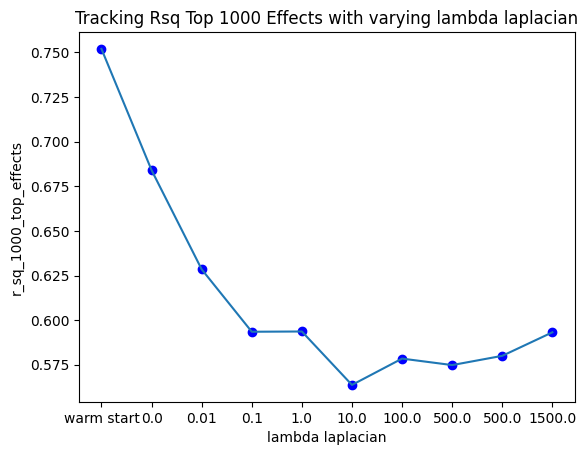

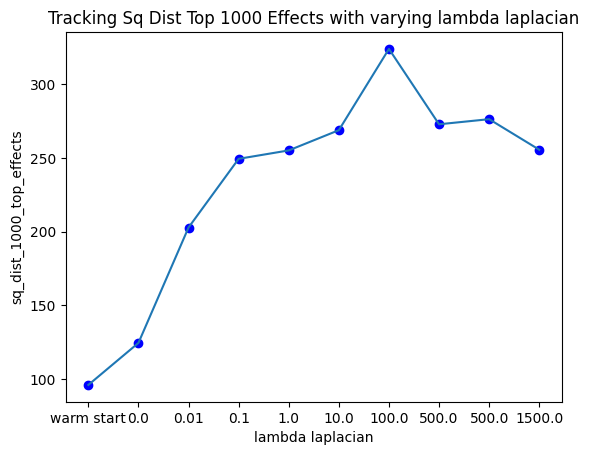

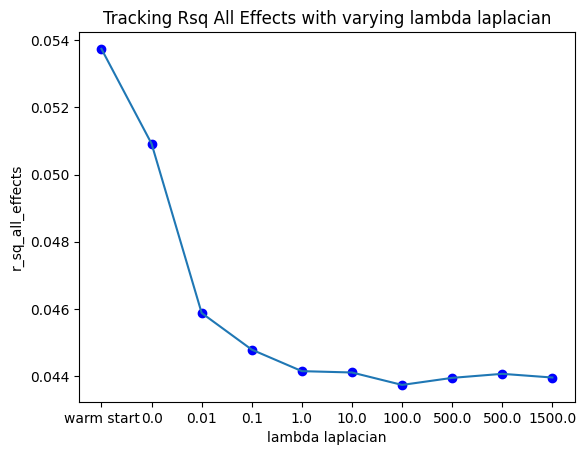

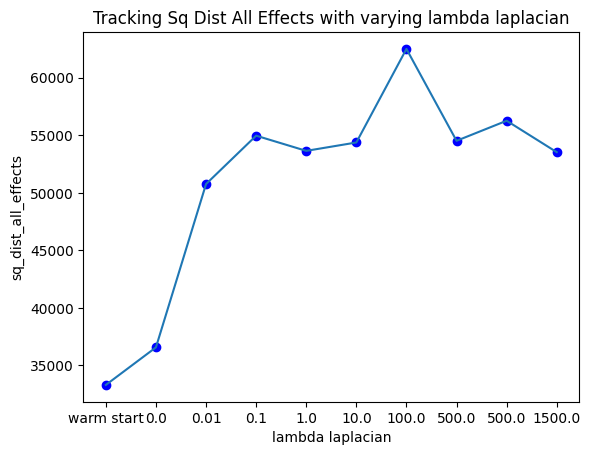

TypeError: ignored

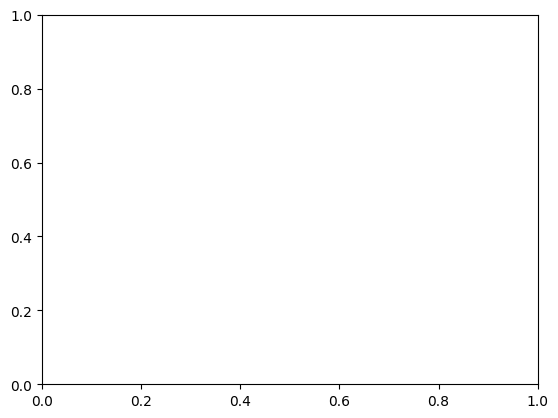

In [ ]:
from scipy import interpolate
var = 'r_sq_1000_top_effects'
variables = ["Rsq Top 1000 Effects","Sq Dist Top 1000 Effects","Rsq All Effects","Sq Dist All Effects"]
a = np.arange(df.shape[0])
for index, var in enumerate(df.columns):
  x=df[var]
  plt.plot(a, df[var], 'bo')
  plt.title(f"Tracking {variables[index]} with varying lambda laplacian")
  plt.xlabel("lambda laplacian")
  plt.ylabel(var)
  plt.xticks(a, df["lambda_laplacian"]) #set the ticks to be a

  x_new = np.arange(df.shape[0])
  bspline = interpolate.make_interp_spline(a, df[var])
  y_new = bspline(x_new)

  # Plot the new data points
  plt.plot(x_new, y_new)
  plt.show()
  plt.clf()



In [ ]:
lapl = analyze(guide_folder="guide_pooled_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_10_55_54", conven_folder="conventional_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_04_03_17_03")
lapl["name"] = 100
df = pd.DataFrame(lapl, index=[0])


In [ ]:
lapl = analyze(guide_folder="guide_pooled_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_07_58_18", conven_folder="conventional_lapl_genes_500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_08_34_46")
lapl["name"] = 500
df = pd.concat([df, pd.DataFrame(lapl, index=[0])])

In [ ]:
lapl = analyze(guide_folder="guide_pooled_lapl_genes_1500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_05_04_53", conven_folder="conventional_lapl_genes_1500_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_05_40_40")
lapl["name"] = 1500
df = pd.concat([df, pd.DataFrame(lapl, index=[0])])

In [ ]:
lapl = analyze(guide_folder="guide_pooled_lapl_genes_0_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_02_04_44", conven_folder="conventional_lapl_genes_0_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_02_40_13")
lapl["name"] = 0
df = pd.concat([df, pd.DataFrame(lapl, index=[0])])

In [ ]:
lapl = analyze(guide_folder="guide_pooled_lapl_genes_1000_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_200_2023_05_30_13_19_55", conven_folder="conventional_lapl_genes_1000_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_200_2023_05_30_13_47_52")
lapl["name"] = 1000
df = pd.concat([df, pd.DataFrame(lapl, index=[0])])

In [ ]:
standard = analyze(guide_folder="guide_pooled_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_00_12", conven_folder="conventional_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_25_03")
standard["name"] = "no laplc"
df = pd.concat([df, pd.DataFrame(standard, index=[0])])

In [ ]:
df

,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,name
0,0.59228,273.130810,0.04365,53602.862720,100
1,0.57410,290.552267,0.04416,57876.615461,500
2,0.58984,274.896899,0.04397,56382.839791,1500
3,0.73003,102.391361,0.05070,34664.190560,0
4,0.59130,263.855535,0.04384,54134.273318,1000
7,0.65673,109.878483,0.04687,33206.172975,no laplc


In [ ]:
lapl_3000 = analyze(guide_folder="guide_pooled_lapl_genes_3000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_17_22_59_41", conven_folder="conventional_lapl_genes_3000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_17_23_28_13")
print("3000", lapl_3000)


3000 {'r_sq_1000_top_effects': 0.25565, 'sq_dist_1000_top_effects': 622.9992790074334, 'r_sq_all_effects': 0.02642, 'sq_dist_all_effects': 69934.04996456382}


In [ ]:
lapl_1000 = analyze(guide_folder="guide_pooled_lapl_genes_1000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_01_22_01", conven_folder="conventional_lapl_genes_1000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_01_52_06")
print("1000", lapl_1000)

1000 {'r_sq_1000_top_effects': 0.31513, 'sq_dist_1000_top_effects': 613.3587941862902, 'r_sq_all_effects': 0.02736, 'sq_dist_all_effects': 66577.43550380188}


In [ ]:
lapl_100 = analyze(guide_folder="guide_pooled_lapl_genes_100_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_21_58_40", conven_folder="conventional_lapl_genes_100_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_22_26_21")
print("100", lapl_100)

100 {'r_sq_1000_top_effects': 0.22619, 'sq_dist_1000_top_effects': 628.6332960926089, 'r_sq_all_effects': 0.02637, 'sq_dist_all_effects': 67420.83157743672}


In [ ]:
lapl_300 = analyze(guide_folder="guide_pooled_lapl_genes_300_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_19_02_46_30", conven_folder="conventional_lapl_genes_300_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_19_03_16_07")
print("300", lapl_300)

300 {'r_sq_1000_top_effects': 0.24873, 'sq_dist_1000_top_effects': 635.84805354851, 'r_sq_all_effects': 0.02467, 'sq_dist_all_effects': 69493.7037325955}


In [ ]:
lapl_500 = analyze(guide_folder="guide_pooled_lapl_genes_500_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_19_00_18_01", conven_folder="conventional_lapl_genes_500_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_19_00_48_01")
print("500", lapl_500)

500 {'r_sq_1000_top_effects': 0.26903, 'sq_dist_1000_top_effects': 637.905175257019, 'r_sq_all_effects': 0.02446, 'sq_dist_all_effects': 63201.76249037415}


In [ ]:
lapl_3000 = analyze(guide_folder="guide_pooled_lapl_genes_3000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_17_22_59_41", conven_folder="conventional_lapl_genes_3000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_17_23_28_13")
print("3000", lapl_3000)

3000 {'r_sq_1000_top_effects': 0.25549, 'sq_dist_1000_top_effects': 605.4580068768172, 'r_sq_all_effects': 0.02653, 'sq_dist_all_effects': 64822.598032617716}


In [ ]:
lapl_5000 = analyze(guide_folder="guide_pooled_lapl_genes_5000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_03_48_22", conven_folder="conventional_lapl_genes_5000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_04_18_25")
print("5000", lapl_5000)

5000 {'r_sq_1000_top_effects': 0.21955, 'sq_dist_1000_top_effects': 677.7039996365984, 'r_sq_all_effects': 0.0232, 'sq_dist_all_effects': 63703.289203292}


In [ ]:
reduce_update = analyze(guide_folder="guide_pooled_lapl_genes_5000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_03_48_22", conven_folder="conventional_lapl_genes_5000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_04_18_25")
print("reduce_update", reduce_update)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-e6e423cb2fa0>", line 1, in <cell line: 1>
    reduce_update = analyze(guide_folder="guide_pooled_lapl_genes_1000_update_lasso_5_lambda_0.1_laplacian_True_epochs_200_2023_05_19_16_06_06", conven_folder="conventional_lapl_genes_1000_update_lasso_5_lambda_0.1_laplacian_True_epochs_200_2023_05_19_16_35_05")
  File "<ipython-input-6-00f9ac9453d6>", line 4, in analyze
    torch_code_conven = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{conven_folder}/code_conventional_final_unrolled.npy").astype(float)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 407, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AM231_project/data/l

In [ ]:
lam = [lapl_100, lapl_300,lapl_500,lapl_1000,lapl_3000,lapl_5000]
values = [100, 300,500,1000,3000,5000]
for index, lamda_ in enumerate(lam):
  lamda_["lambda"] = values[index]
  df = pd.DataFrame(lamda_, index=[0])
  if index == 0:
    df_final = df
  else:
    df_final = pd.concat([df_final, df]).reset_index(drop=True)



In [ ]:
df_final

,r_sq_1000_top_effects,sq_dist_1000_top_effects,r_sq_all_effects,sq_dist_all_effects,lambda
0,0.22619,628.633296,0.02637,67420.831577,100
1,0.24873,635.848054,0.02467,69493.703733,300
2,0.26903,637.905175,0.02446,63201.762490,500
3,0.31513,613.358794,0.02736,66577.435504,1000
4,0.25565,622.999279,0.02642,69934.049965,3000
5,0.21955,677.704000,0.02320,63703.289203,5000


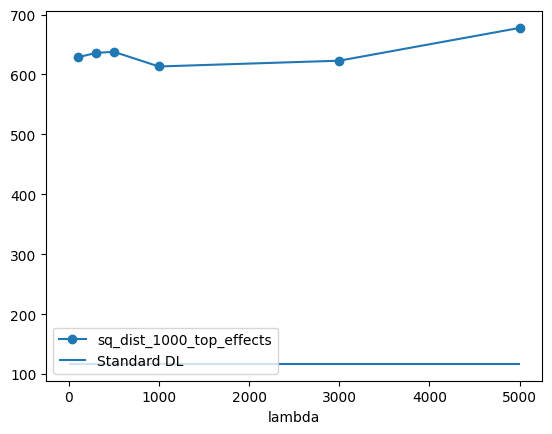

In [ ]:
df_final.plot(x="lambda", y="sq_dist_1000_top_effects", marker='o')
plt.hlines(116.82958644221799, xmin=0, xmax=5000, label = "Standard DL")
plt.legend()

<Axes: xlabel='lambda'>

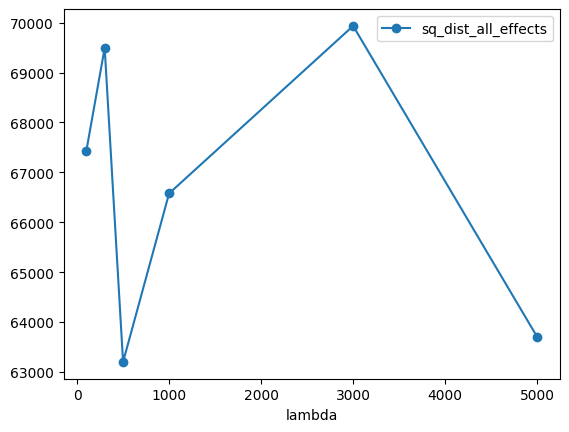

In [ ]:
df_final.plot(x="lambda", y="sq_dist_all_effects", marker='o')